# Teoría del portafolio moderno aplicada (Efficient Frontier) - Daniel Ramos

Definimos a la "Efficient frontier" como un set de portafolios de inversión de los cuales se espera el maximo retorno en base a una adversión al riesgo dada.

Se considera un portafolio eficiente si no existe otro portafolio que ofrezca mayores retornos por el mismo riesgo, esto con base a un set dado de intrumentos de inversión.


En este proyecto flash emplearemos un portafolio centrado en el "value investing". Es decir, los instrumentos dentro de nuestro portafolio son los top lideres de su industria o bien son acciones que destacan por tener modelos de negocio bastante solidos. Por otro lado, se trata de balancear a el beta del portafolio entre activos muy volatiles (BTC, tesla) con activos con menor volatilidad (BRK-B,Visa). 

A pesar de tratar de manejar el riesgo de nuestro portafolio, es necesario tomar en cuenta que este portafolio en particular no considera reservas de cash liquidiy.



# Código

In [1]:
#Importamos las librerias que usaremos

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import yfinance as yf
import seaborn as sns
from pandas_datareader import data as pdr
yf.pdr_override()


In [26]:
#Definimos los parametros de entrada: stocks, inicio del portafolio, final del protafolio

tickers=['V','AAPL','JD','TSLA','BRK-B','TDG','LNG','DPZ']
start = dt.datetime(2014, 10, 31)
end = dt.datetime(2023, 2, 28)

In [27]:
#Definimos los retornos como un dataframe para el mejor manejo e implementación

returns=pd.DataFrame()

#Descargamos la data de cierre diario para cada stock dentro de tickers.
for ticker in tickers:
    data = pdr.get_data_yahoo(ticker, start=start, end=end)
    data = pd.DataFrame(data)
    data[ticker] = data['Adj Close'].pct_change()

    if returns.empty:
        returns = data[[ticker]]
    else:
        returns = returns.join(data[[ticker]], how='outer')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Simulación Monte Carlo

A diferencia de un modelo de pronóstico normal, la simulación Monte Carlo predice un conjunto de resultados basados en un rango estimado de valores frente a un conjunto de valores de entrada fijos. En otras palabras, una simulación Monte Carlo crea un modelo de posibles resultados al utilizar una distribución de probabilidades, como una distribución uniforme o normal, para cualquier variable que tenga una incertidumbre inherente. Luego, recalcula los resultados una y otra vez, cada vez mediante un conjunto diferente de números aleatorios entre los valores mínimo y máximo.

En este caso utilizamos esta simulación para crear un universo de portafolios téoricos.

In [28]:
#pesos en cartera, iterador y arrays para simulacion
iterations=25000
port_weights=[]
port_returns=[]
port_risk=[]
sharpes=[]


In [29]:
#simulación montecarlo

for port in range(iterations):
    weights=np.random.random(len(tickers))
    weights= np.round(weights/np.sum(weights),3)
    port_weights.append(weights)
    
    #Anualizado, si fuese para cripto usamos 365 en vez de 252
    annualized_returns=np.sum(returns.mean()*weights)*252
    port_returns.append(annualized_returns)
    
    #matriz de covarianza y riesgo
    cov=returns.cov()*252
    port_variance= np.dot(weights.T,np.dot(cov,weights))
    port_std=np.sqrt(port_variance)
    port_risk.append(port_std)
    
    #sharpe ratio, asumiendo el risk free como 0
    sharpe= annualized_returns/port_std
    sharpes.append(sharpe)
    

In [30]:
#Definimos los posibles retornos, riesgos y sharpe ratios como arrays de numpy

port_returns=np.array(port_returns)
port_risk=np.array(port_risk)
sharpes=np.array(sharpes)

In [31]:
port_stats=[port_returns,port_risk,sharpes,port_weights]
port_df=pd.DataFrame(port_stats).T
port_df.columns=['returns','risk','sharpes','weights']

#pasamos de str a floats

port_df['returns'] = port_df['returns'].astype(float)
port_df['risk'] = port_df['risk'].astype(float)
port_df['sharpes'] = port_df['sharpes'].astype(float)

#Minimum Variance Portfolios para cada caso (MVPs)
mvp_risk=port_df.iloc[port_df['risk'].astype(float).idxmin()]
mvp_returns=port_df.iloc[port_df['returns'].astype(float).idxmax()]
mvp_sharpe=port_df.iloc[port_df['sharpes'].astype(float).idxmax()]


# Visualización de data

En esta instancia ya contamos con todos los datos necesarios para llegar a conclusiones "data-driven". 

estaremos usando seaborn y matplotlib para mostar información relevante sobre este proyecto flash.


En este particular caso nos interesa saber cual es el sharpe ratio máximo, cuales son los retornos máximos y cual es el riesgo mínimo. Extraeremos esta data para buscar dar soluciones a distintos perfiles de inversor con este "basket" de activos-

# Performance 

Gracias a los dataframes de pandas podemos dar estructura a nuestra data, y con ayuda de seaborn mostrarla para resonar de forma más efectiva con el stake holder.

Como se muestra en la siguiente figura: todos los perfiles de portafolios a evaluar cuentan con un sharpe ratio positivo, esto es una buena señal, ya que implica que tendemos a más retornos por menos riesgos.

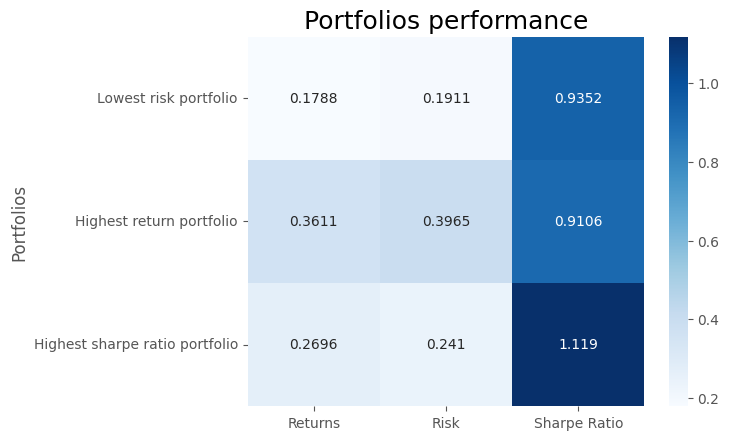

In [32]:
# Crear un dataframe con los performance de cada portafolio
performance_df = pd.DataFrame({
    "Portfolios": ["Lowest risk portfolio", "Highest return portfolio", "Highest sharpe ratio portfolio"],
    "Returns": [mvp_risk["returns"], mvp_returns["returns"], mvp_sharpe["returns"]],
    "Risk": [mvp_risk["risk"], mvp_returns["risk"], mvp_sharpe["risk"]],
    "Sharpe Ratio": [mvp_risk["sharpes"], mvp_returns["sharpes"], mvp_sharpe["sharpes"]],
})

# Definir el índice del dataframe
performance_df = performance_df.set_index("Portfolios")

# Mostramos el dataframe utilizando la función heatmap de seaborn
sns.heatmap(performance_df, annot=True, cmap="Blues", fmt=".4g")
plt.title('Portfolios performance', fontsize=18)
plt.show()

# Distribución de cartera

Una vez se conocen los posibles riesgos y recompensas de cada uno de los 3 portafolios, es hora de examinar el peso que tendría cada activo del basket seleccionado en cada uno de los 3 casos.

Una vez más se realiza con Seaborn

In [33]:
# Se crea un DataFrame con los pesos de las tres carteras MVP
df = pd.DataFrame({'Lowest risk portfolio': mvp_risk['weights'], 
                   'Highest return portfolio': mvp_returns['weights'], 
                   'Highest sr portfolio': mvp_sharpe['weights']}, 
                  index=tickers)

# mostramos el DataFrame (raw data)
print(df)

       Lowest risk portfolio  Highest return portfolio  Highest sr portfolio
V                      0.179                     0.003                 0.176
AAPL                   0.054                     0.041                 0.256
JD                     0.008                     0.104                 0.000
TSLA                   0.017                     0.619                 0.171
BRK-B                  0.298                     0.095                 0.015
TDG                    0.044                     0.017                 0.157
LNG                    0.142                     0.013                 0.026
DPZ                    0.258                     0.109                 0.200


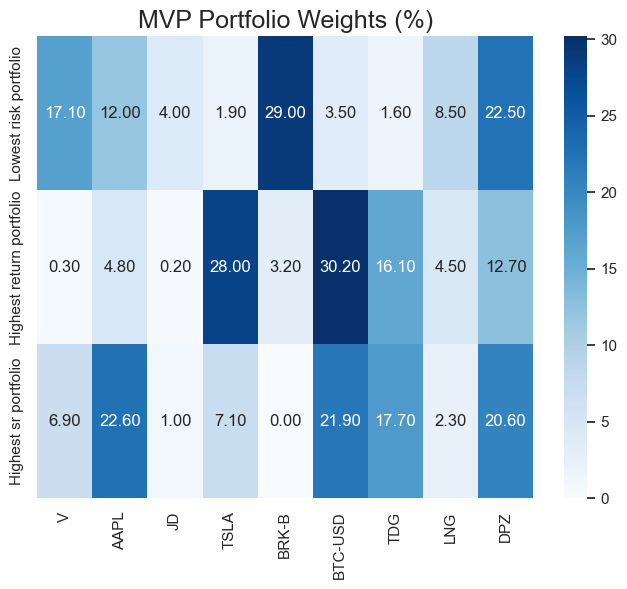

In [24]:
# heatmap con Seaborn de los weights en cada portafolio MVP

sns.set(style="dark")
plt.figure(figsize=(8,6))
sns.heatmap(df.T*100, annot=True, cmap='Blues', fmt='.2f', cbar=True)
plt.title('MVP Portfolio Weights (%)', fontsize=18)
plt.show()

# Efficient frontier

Ya conocemos las implicaciones y distribuciones téoricas de cada portafolio. 

Al momento de visualizar la simulación hecha anteriormente, se logra observar los 3 puntos de interés. Se puede observar el portafolio tangencial (portafolio del mercado), el cual, basado en la teoría de harry markowitz sería la mejor opción dado el basket elegido al inicio del proyecto. 


Viendolo graficamente, podemos observar que hace sentido, puesto no solo los S.Ratios del portafolio con minima volatilidad y maximos retornos es muy similar, sino qué, al tomar cualquiera de ambos estamos teniendo valor esperado negativo (-EV) con respecto a tomar el portafolio tangencial.

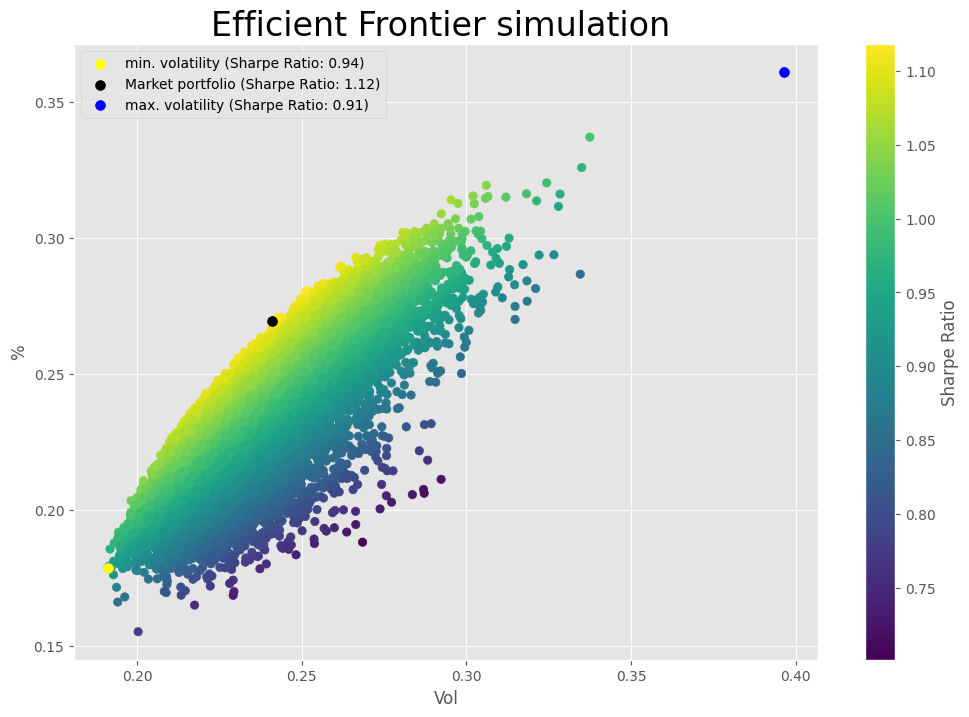

In [34]:
#plot simulacion de portafolios
style.use('ggplot')

plt.figure(figsize=(12,8))
plt.scatter(port_risk,port_returns, c=(port_returns/port_risk))
plt.title("Efficient Frontier simulation ", fontsize=24)
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(mvp_risk['risk'], mvp_risk['returns'],c='yellow', s=50,label='min. volatility (Sharpe Ratio: {:.2f})'.format(mvp_risk['sharpes']))
plt.scatter(mvp_sharpe['risk'], mvp_sharpe['returns'],c='black', s=50, label="Market portfolio (Sharpe Ratio: {:.2f})".format(mvp_sharpe['sharpes']))
plt.scatter(mvp_returns['risk'], mvp_returns['returns'],c='blue', s=50, label='max. volatility (Sharpe Ratio: {:.2f})'.format(mvp_returns['sharpes']))

plt.xlabel("Vol")
plt.ylabel("%")
plt.legend()
plt.show()


# Conclusiones

En conclusión, se puede validar que para el basket de activos: 
Visa Inc.
Apple Inc.
JD.com, Inc.
Tesla, Inc.
Berkshire Hathaway Inc.
Bitcoin (USD)
TransDigm Group Incorporated
Cheniere Energy, Inc.
Domino's Pizza, Inc.

la mejor manera de posicionar el balance de la cartera sería tomando los weights del portafolio con máximo sharpe ratio.

Teniendo este, una mejor distribución en cuanto a su varianza y dispersión. 

# Bibliografía

1. Corporate Finance Institute. (2023, 16 marzo). Modern Portfolio Theory (MPT). https://corporatefinanceinstitute.com/resources/capital-markets/modern-portfolio-theory-mpt/

2. ¿Qué es la simulación Monte Carlo? | IBM. (s. f.). https://www.ibm.com/mx-es/topics/monte-carlo-simulation

